<code>plot_RMSE_ratio_VRILE_vs_noVRILE.ipynb</code> plots RMSE as a function of lead time for ALL DAYS for all S2S models.  We actually plot the ratio of RMSE on VRILE days to the RMSE on nonVRILE days. 

In [1]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from S2S_sea_ice_plotting import RMSE_plot_ratio, RMSE_plot_actual

### Inputs:
* <code>model_names</code>: which models to include (helpful for debugging)
* <code>seas_str</code>: which season to plot (string) (for this notebook, we'll just do ALL)
* <code>seas_sel</code>: months to include (array) (all months for this notebook)
* <code>vrile_thresh</code>: threshold for VRILE calculation (string)
* <code>clim_freq</code>: lead time in days or weeks (string)
* <code>TO_PLOT</code>: are we plotting SIE or SIE anom?
* <code>obs_name</code>: which set of obs to use (string)
* <code>obs_name_plt</code>: name of obs (for plot, string)
* <code>ALL_DAYS</code>: boolean; if true, include VRILE and nonVRILE days; if false, just use nonVRILE days

In [2]:
ALL_REGIONS = False 
model_names = ['ecmwf','ukmo','metreofr','ncep','DAMPED_ANOMALY']
#model_names = ['DAMPED_ANOMALY']
#seas_str_ALL = ['JFM','JAS']
seas_str = 'JJA'
seas_sel = [1,2,3,4,5,6,7,8,9,10,11,12]
vrile_thresh = '05'
clim_freq = 'WEEKLY'
TO_PLOT = 'SIE anom RMSE'
obs_name = 'NSIDC_0079'
obs_name_plt = 'NASA Bootstrap'
ALL_DAYS = True

### Steps
1. Load on RMSE spreadsheets for all days and VRILE days, and combine all models into one spreadsheet 
2. Plot RMSE vs lead time for specified season for desired regions. 

Load <code>.csv</code> files

In [3]:
d_SIE_all = pd.DataFrame()
fpath_load = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/data/'
#for seas_str in seas_str_ALL:
for i_model in model_names:
    # Damped anomaly has different filename
    if i_model == 'DAMPED_ANOMALY':
        fpath_all = fpath_load+'{model_name}_{obs_name}/OBS_{obs_name}/'.format(model_name=i_model,obs_name=obs_name)       
        fpath_all = fpath_all+'COMMON_RF/VRILE_vs_NOVRILE_RMSE_MAE_{model_name}_{obs_name}_months{seas_str}_VRILE{vrile_thresh}_model_clim_freq_{clim_freq}.csv'.format(model_name=i_model,
                                                                                obs_name=obs_name,seas_str=seas_str,
                                                                                            vrile_thresh=vrile_thresh,
                                                                                            clim_freq=clim_freq)
        d_SIE = pd.read_csv(fpath_all)
        d_SIE['Model Name'] = 'Damped Anomaly'
        d_SIE['Season'] = seas_str
        d_SIE_all = d_SIE_all.append(d_SIE)

    else:
        # Load ALL DAYS
        fpath_all = fpath_load+'{model_name}/OBS_{obs_name}/COMMON_RF/VRILE_vs_NOVRILE_RMSE_MAE_{model_name}_months{seas_str}_VRILE{vrile_thresh}_model_clim_freq_{clim_freq}.csv'.format(model_name=i_model,
                                                                                                obs_name=obs_name,
                                                                                                seas_str=seas_str,
                                                                                                vrile_thresh=vrile_thresh,
                                                                                                clim_freq=clim_freq)
        d_SIE = pd.read_csv(fpath_all)
        # Because we spelled "meteofr" wrong
        if i_model == 'metreofr':
            d_SIE['Model Name'] = 'meteofr'
        else:
            d_SIE['Model Name'] = i_model
        # 
        d_SIE['Season'] = seas_str
        d_SIE_all = d_SIE_all.append(d_SIE)



In [4]:
fpath_all

'/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/data/DAMPED_ANOMALY_NSIDC_0079/OBS_NSIDC_0079/COMMON_RF/VRILE_vs_NOVRILE_RMSE_MAE_DAMPED_ANOMALY_NSIDC_0079_monthsJJA_VRILE05_model_clim_freq_WEEKLY.csv'

Trim regions

In [5]:
regions_all = d_SIE_all['region'].unique().tolist()
regions_drop = ['St John']#,'Hudson Bay','Canadian Islands','Bering','Sea of Okhotsk']
regions_sel = d_SIE_all[~d_SIE_all['region'].isin(regions_drop)]['region'].unique().tolist()
if ALL_REGIONS == True:
    regions_list = regions_sel
    ncols = 5
    reg_save_str = 'REG_ALL'
    fpath_save = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/figures/RMSE_all_days/'
    ftype = 'pdf'
else:
    regions_list = ['panArctic','Barents Sea','East Greenland Sea','Central Arctic','Kara-Laptev Sea',
                     'East Siberian-Beaufort-Chukchi Sea','Bering']
    ncols = 2
    reg_save_str = 'REG_TRIM'
    fpath_save = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/figures/RMSE_all_days/'
    ftype='pdf'
if not os.path.exists(fpath_save):
    os.makedirs(fpath_save)

In [6]:
d_SIE_all = d_SIE_all[~d_SIE_all['region'].isin(regions_drop)]

Shorten region names and replace to plot in desired order

In [7]:
d_SIE_all['region'] = d_SIE_all['region'].replace({'East Greenland Sea':'E. Greenland Sea',
    'East Siberian-Beaufort-Chukchi Sea':'E. Sib./Beauf./Chuk. Sea'})
#model_R2_select['Model Name'] = model_R2_select['Model Name'].replace({'metreofr':'meteofr'})
#
d_SIE_all['Model Name'] = d_SIE_all['Model Name'].replace({'ecmwf':'ECMWF','ukmo':'UKMO','meteofr':'METEOFR',
                                                       'ncep':'NCEP'})

if (seas_str == 'JFM') | (seas_str == 'DJF') | (seas_str == 'DJFM'):  
    regions_sort = ["panArctic","E. Greenland Sea","Bering"]
elif (seas_str == 'ALL'):
    regions_sort = ["panArctic","Central Arctic","E. Sib./Beauf./Chuk. Sea","Kara-Laptev Sea",
                "Barents Sea","E. Greenland Sea","Bering"]
else:
    regions_sort = ["panArctic","Central Arctic","E. Sib./Beauf./Chuk. Sea","Kara-Laptev Sea",
                "Barents Sea","E. Greenland Sea"]
d_SIE_all['region sort'] = pd.Categorical(d_SIE_all['region'],regions_sort)


We also need to mask out lead times where we cannot significantly distinguish VRILE days from nonVRILE days

In [8]:
SIE_df_ALL = d_SIE_all.groupby(['region sort','Model Name','type','lead days','year out']).mean().reset_index()
pval_thresh = 1.96
if TO_PLOT == 'SIE anom RMSE':
    pval_str = 'p-value anom'
elif TO_PLOT == 'SIE RMSE':
    pval_str = 'p-value'
SIE_df_pmask = SIE_df_ALL.mask(abs(SIE_df_ALL[pval_str])<pval_thresh)
SIE_df_pmask_count = SIE_df_pmask.groupby(['Model Name','region sort','type','lead days'])[pval_str,'sample size'].count()

SIE_df_RMSE_all = SIE_df_ALL.groupby(['Model Name','region sort','type','lead days'])['SIE RMSE','SIE MAE','SIE anom RMSE','SIE anom MAE',pval_str].mean()
SIE_df_pmask_RMSE = SIE_df_pmask.groupby(['Model Name','region sort','type','lead days'])['SIE RMSE','SIE MAE','SIE anom RMSE','SIE anom MAE',pval_str].mean()

/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # Remove the CWD from sys.path while we load stuff.
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # This is added back by InteractiveShellApp.init_path()


Now, based on our binomial distribution, we have determined that we need at least 13 of 16 folds to be significant for the RMSE on that lead day / region / model combination to be significant at 95% (that is, we need RMSE on VRILE days vs non-VRILE days to be significantly different for at least 13 of 16 folds for us to be able to reject the null hypothesis--that VRILE days are not significantly different from non-VRILE days).

At 90% we need 12 folds to be significant.

In [9]:
alpha_sel = 0.05
if alpha_sel == 0.05:
    fold_no = 13
elif alpha_sel == 0.1:
    fold_no = 12
else:
    for i_a in np.arange(16,0,-1):
        print(i_a)
        a_max = scipy.stats.binom_test(i_a,16, p=0.5, alternative='two-sided')
        if ((a_max > alpha) == True):
            print('use ',i_a+1,' folds')
            fold_no = i_a+1
            break
            
SIE_df_mask_folds = SIE_df_pmask_RMSE.mask(SIE_df_pmask_count[pval_str] < fold_no)

In [10]:
SIE_df_mask_folds.xs(('UKMO','panArctic'))

SIE RMSE   SIE MAE  SIE anom RMSE  SIE anom MAE  \
type          lead days                                                    
VRILE days    0.0        0.543427  0.443720       0.397102      0.343400   
              1.0        0.821418  0.741148       0.306411      0.265929   
              2.0        0.736305  0.655550       0.278428      0.230523   
              3.0        0.679908  0.551536       0.294114      0.211139   
              4.0        0.541388  0.364864       0.362918      0.256231   
              5.0        0.482832  0.345496       0.384383      0.297231   
              6.0             NaN       NaN            NaN           NaN   
              7.0             NaN       NaN            NaN           NaN   
              8.0        0.478668  0.410132       0.249913      0.209182   
no VRILE days 0.0        0.387373  0.295523       0.298298      0.255239   
              1.0        0.618363  0.511633       0.269294      0.219276   
              2.0        0.756233  0.617392       0.301888      0.236090   
              3.0        0.813576  0.639170       0.321375      0.243972   
              4.0        0.831463  0.621911       0.333501      0.247896   
              5.0        0.782873  0.557006       0.334339      0.245178   
              6.0             NaN       NaN            NaN           NaN   
              7.0             NaN       NaN            NaN           NaN   
              8.0        0.551129  0.408559       0.291898      0.232373   

                         p-value anom  
type          lead days                
VRILE days    0.0            6.888126  
              1.0            7.402877  
              2.0            1.962238  
              3.0            2.182036  
              4.0            2.059198  
              5.0            2.959595  
              6.0                 NaN  
              7.0                 NaN  
              8.0           -3.640121  
no VRILE days 0.0            6.888126  
              1.0            7.402877  
              2.0            1.962238  
              3.0            2.182036  
              4.0            2.059198  
              5.0            2.959595  
              6.0                 NaN  
              7.0                 NaN  
              8.0           -3.640121

Group by region, lead day, model, and type (all days or non-VRILE days only, based on <code>ALL_DAYS</code>)

In [11]:
d_SIE_all_gb = d_SIE_all.groupby(['region sort','Season','Model Name','type','lead days']).mean()
d_SIE_all_ratio = d_SIE_all_gb.xs('VRILE days',level=3)/d_SIE_all_gb.xs('no VRILE days',level=3)
#d_SIE_all_ratio = d_SIE_all.xs('VRILE days',level=3)/d_SIE_all.xs('no VRILE days',level=3)
#d_SIE_all_gb.xs(('E. Sib./Beauf./Chuk. Sea',seas_str,'UKMO'))
#SIE_df_pmask.groupby(['region sort','Model Name','type','lead days']).mean().xs(('Kara-Laptev Sea','NCEP'))

In [12]:
#SIE_df_mask_folds.xs('UKMO',level=2)
SIE_df_mask_gb = SIE_df_mask_folds.reset_index().groupby(['region sort','Model Name','type','lead days']).mean()
SIE_df_mask_gb_ratio = SIE_df_mask_gb.xs('VRILE days',level=2)/SIE_df_mask_gb.xs('no VRILE days',level=2)
#SIE_df_mask_gb.xs(('E. Sib./Beauf./Chuk. Sea','UKMO'))


In [13]:
if TO_PLOT == 'SIE RMSE':
    title_str = 'Sea Ice Extent'
    save_str = 'SIE'
else:
    title_str = 'Anomalous Sea Ice Extent'
    save_str = 'SIE_anom'

Plot

/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/figures/RMSE_all_days/RMSE_ratio_SIE_anom_JJA_NSIDC_0079.pdf


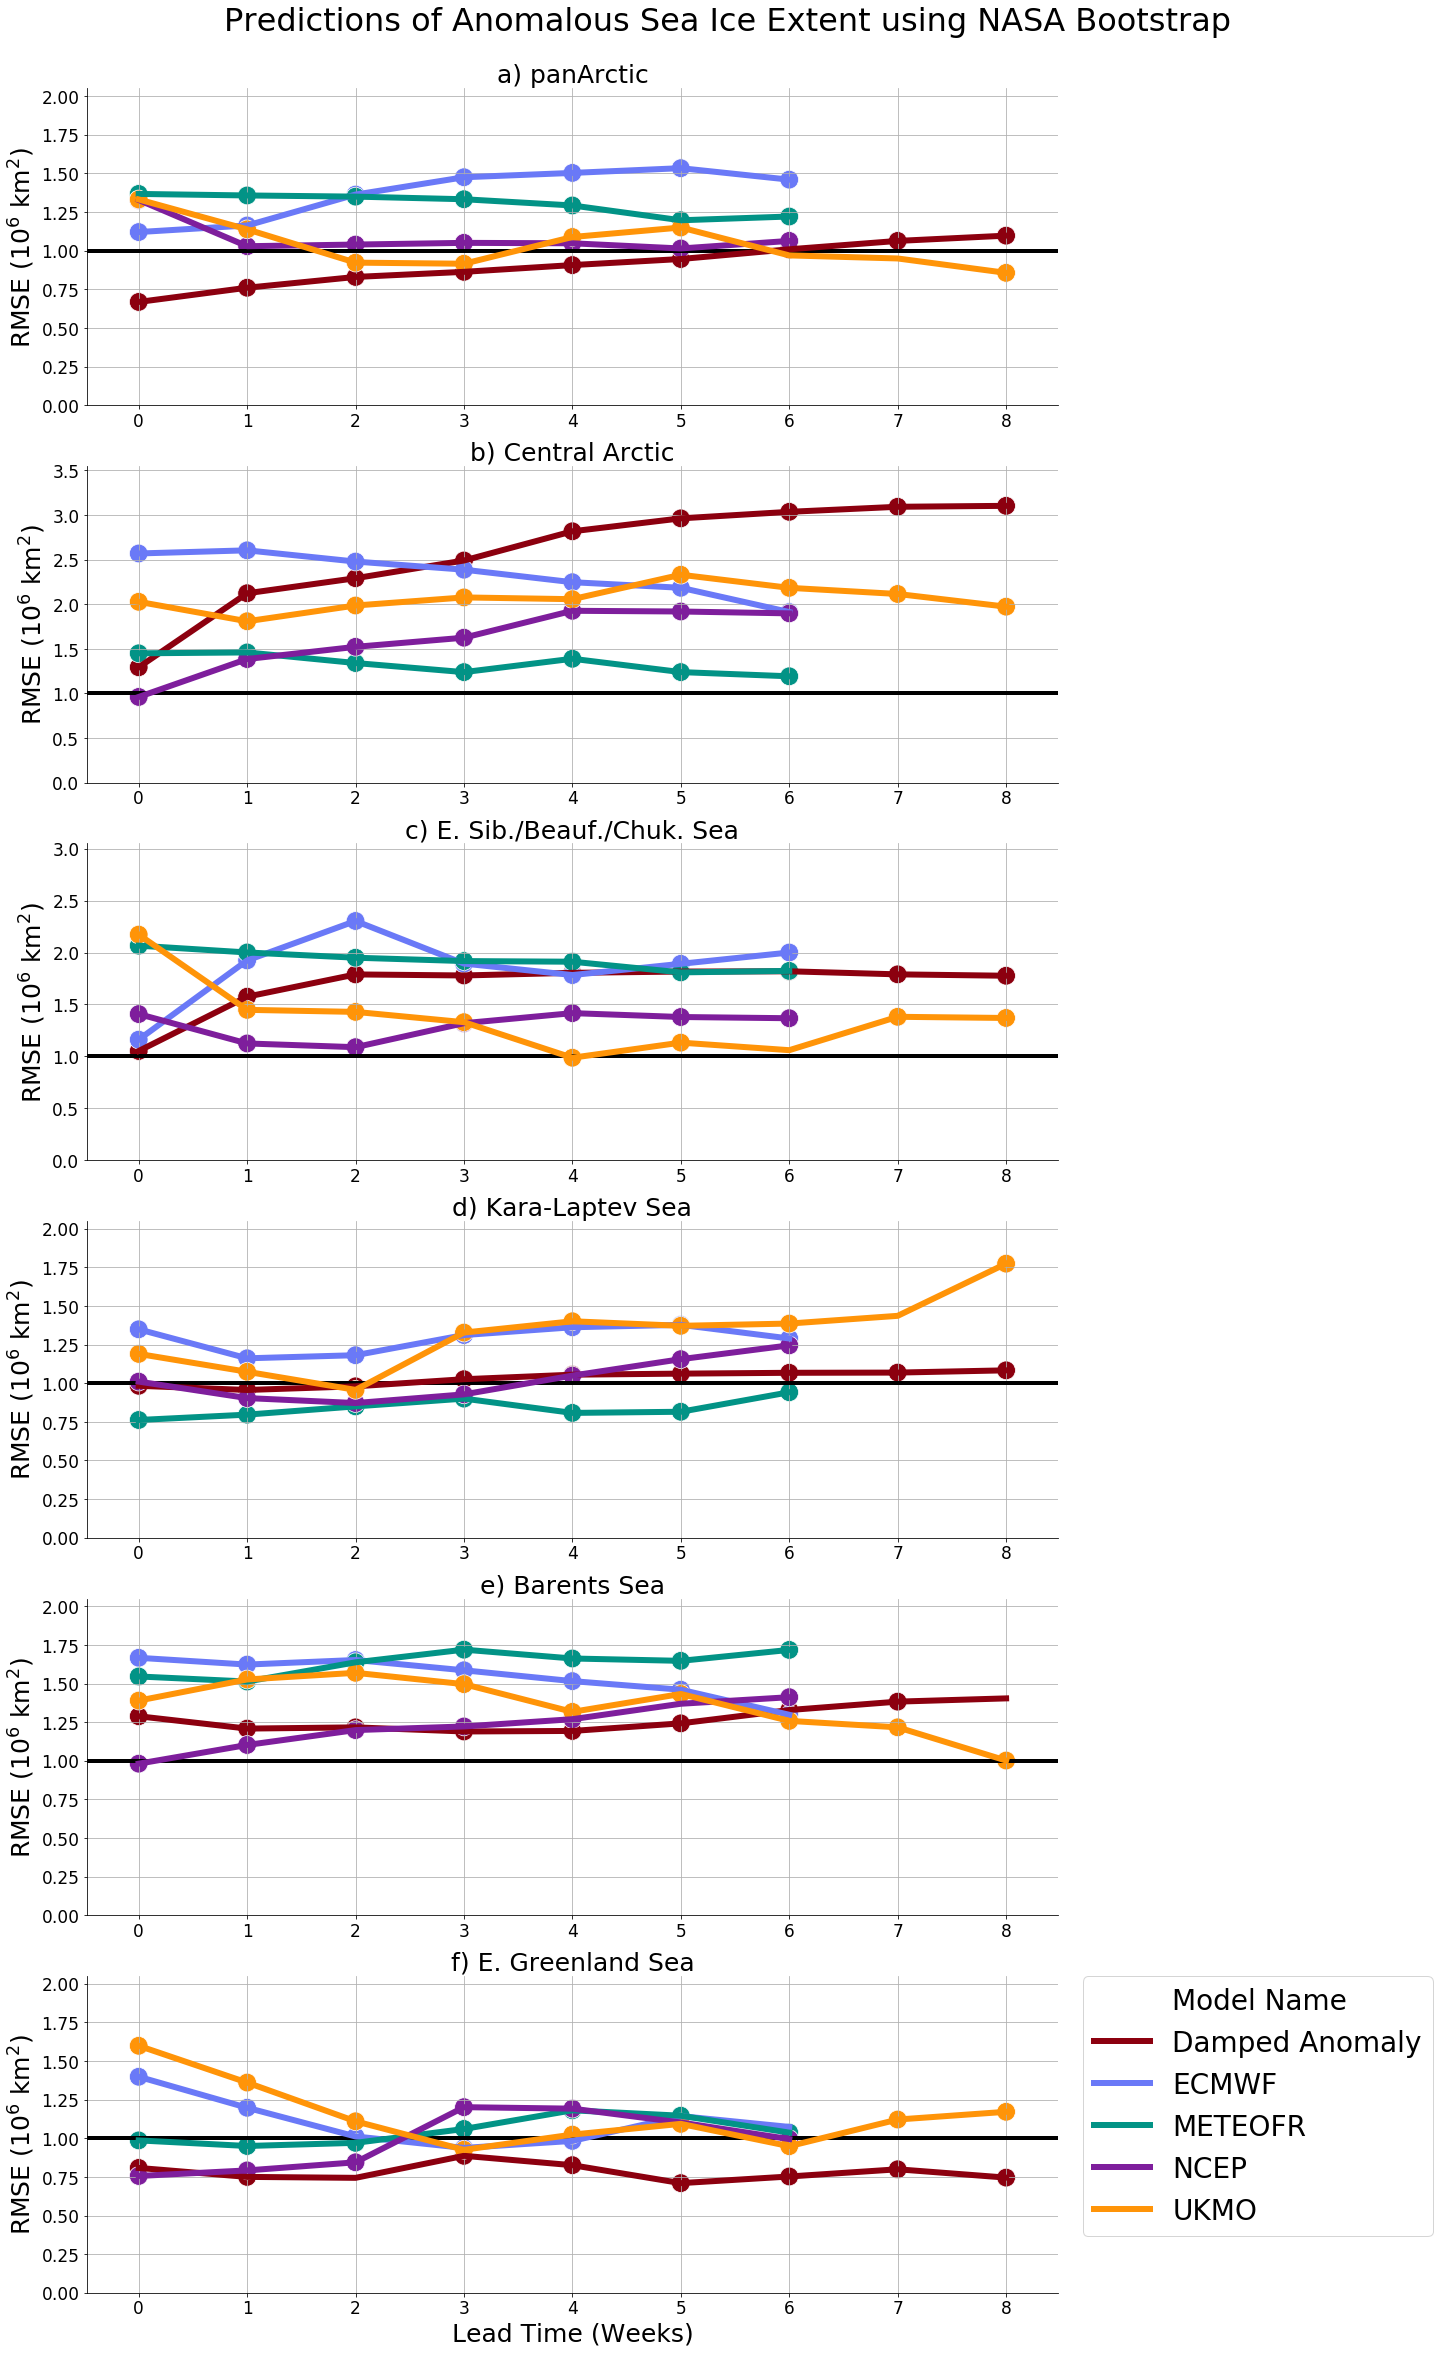

In [20]:
no_regions = len(regions_sort)
nrows = no_regions
ncols = 1
if TO_PLOT == 'SIE RMSE':
    vmax = [2.55,3.55,3.05,2.55,3.255,2.55,2.5]
else:
    vmax = [2.05,3.55,3.05,2.05,2.05,2.05,2.5]
    
vmin = 0
fig1,ax1 = plt.subplots(nrows,ncols,figsize=(20,32))
for i in range(0,no_regions):
    ax_sel = ax1.flat[i]
    #i_reg = np.floor(i/2).astype(int)
    i_reg = i
    reg_sel = regions_sort[i_reg]
    #if np.mod(i,2) == 0:
    data_sel = d_SIE_all_ratio.xs((reg_sel)).reset_index()
    data_scatt = SIE_df_mask_gb_ratio.xs((reg_sel)).reset_index()
    #elif np.mod(i,2) == 1:
     #   data_sel = d_SIE_all_gb2.xs((reg_sel)).reset_index()
    # Plot
    ax_sel.axhline(1,linewidth=4,color='k')
    RMSE_plot_ratio(ax_sel,data_sel,data_scatt,reg_sel,TO_PLOT,i,vmin,vmax[i_reg],no_regions,ncols,nrows)
    #ax_sel.set_title('{reg_sel}, {seas_sel}'.format(reg_sel=reg_sel,seas_sel=seas_str_sel),fontsize=24)
    
    #if i == nrows*ncols-1:
   #     leg = ax_sel.legend(bbox_to_anchor=(1.025,1),loc=2,borderaxespad=0,fontsize=20)
     #   for legob in leg.get_lines():
    #        legob.set_linewidth(6.0)
  #  else:
    #    leg = ax_sel.legend()
    #    leg.remove()
#fig1.delaxes(ax=ax1.flat[7])        
fig1.tight_layout()

if TO_PLOT == 'SIE RMSE':
    fig1.suptitle('Predictions of Sea Ice Extent using {obs_name}'.format(obs_name=obs_name_plt),fontsize=32,y=1.02)
else:
    fig1.suptitle('Predictions of Anomalous Sea Ice Extent using {obs_name}'.format(obs_name=obs_name_plt),fontsize=32,y=1.02)
#if ALL_DAYS == True:
   # fpath_save1 = fpath_save+'ALL_DAYS_{save_str}_{seas_str1}_{seas_str2}_RMSE_only_{obs_name}.pdf'.format(save_str=save_str,seas_str=seas_str,
    #                                                    seas_str1=seas_str_ALL[0],seas_str2=seas_str_ALL[1],obs_name=obs_name)
#elif ALL_DAYS == False:
fpath_save1 = fpath_save+'RMSE_ratio_{save_str}_{seas_str}_{obs_name}.pdf'.format(save_str=save_str,
                                                    seas_str=seas_str,obs_name=obs_name)
fig1.savefig(fpath_save1,format='pdf',bbox_inches='tight')  
print(fpath_save1)

'SIE_anom'

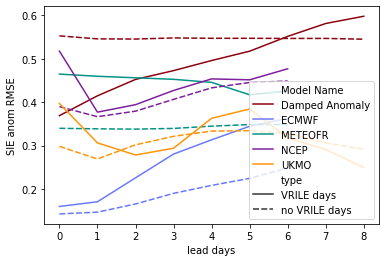

In [15]:
import seaborn as sns
sns.lineplot(data=d_SIE_all_gb.xs('panArctic').reset_index(),x='lead days',y='SIE anom RMSE',hue='Model Name',
            style='type')
save_str

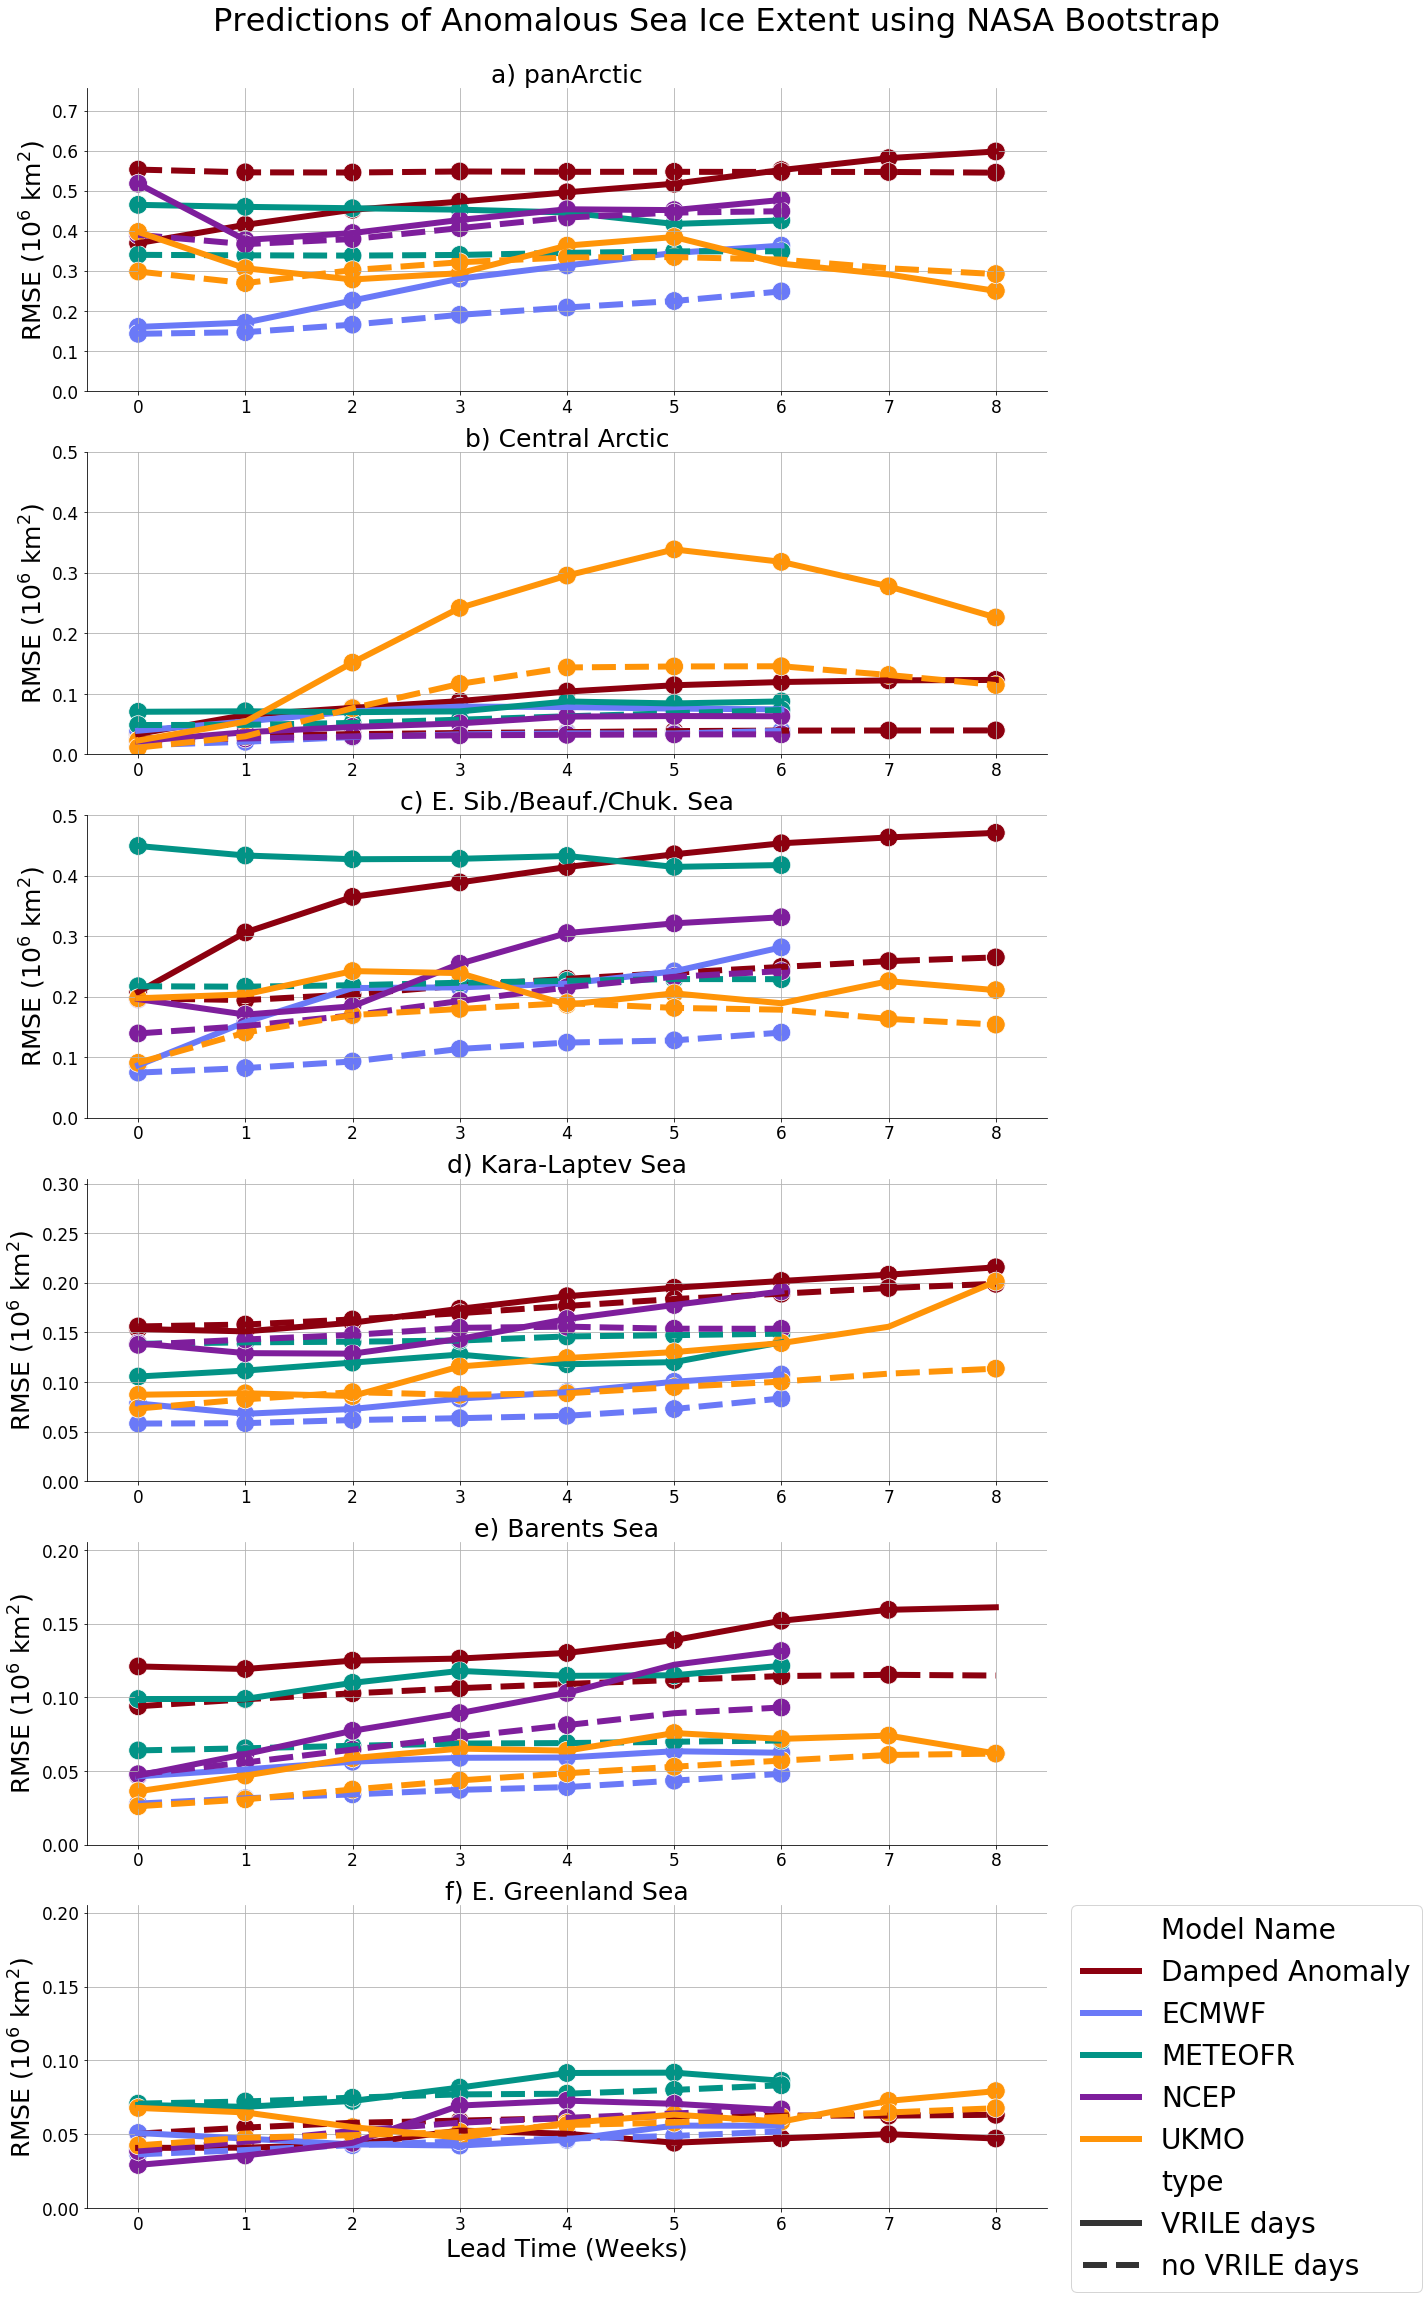

In [16]:
no_regions = len(regions_sort)
nrows = no_regions
ncols = 1
if TO_PLOT == 'SIE RMSE':
    vmax = [1.25,0.805,0.805,0.405,0.305,0.305,0.5]
else:
    vmax = [0.755,0.5,0.5,0.305,0.2055,0.205,0.5]
    
vmin = 0
fig2,ax2 = plt.subplots(nrows,ncols,figsize=(20,32))
for i in range(0,no_regions):
    ax_sel = ax2.flat[i]
    #i_reg = np.floor(i/2).astype(int)
    i_reg = i
    reg_sel = regions_sort[i_reg]
    #if np.mod(i,2) == 0:
    data_sel = d_SIE_all_gb.xs((reg_sel)).reset_index()
    data_scatt = SIE_df_mask_gb.xs((reg_sel)).reset_index()
    #elif np.mod(i,2) == 1:
     #   data_sel = d_SIE_all_gb2.xs((reg_sel)).reset_index()
    # Plot
    #ax_sel.axhline(1,linewidth=4,color='k')
    RMSE_plot_actual(ax_sel,data_sel,data_scatt,reg_sel,TO_PLOT,i,vmin,vmax[i_reg],no_regions,ncols,nrows)
    #ax_sel.set_title('{reg_sel}, {seas_sel}'.format(reg_sel=reg_sel,seas_sel=seas_str_sel),fontsize=24)
    
    #if i == nrows*ncols-1:
   #     leg = ax_sel.legend(bbox_to_anchor=(1.025,1),loc=2,borderaxespad=0,fontsize=20)
     #   for legob in leg.get_lines():
    #        legob.set_linewidth(6.0)
  #  else:
    #    leg = ax_sel.legend()
    #    leg.remove()
#fig1.delaxes(ax=ax1.flat[7])        
fig2.tight_layout()

if TO_PLOT == 'SIE RMSE':
    fig2.suptitle('Predictions of Sea Ice Extent using {obs_name}'.format(obs_name=obs_name_plt),fontsize=32,y=1.02)
else:
    fig2.suptitle('Predictions of Anomalous Sea Ice Extent using {obs_name}'.format(obs_name=obs_name_plt),fontsize=32,y=1.02)
fpath_save2 = fpath_save+'RMSE_only_{save_str}_{seas_str}_{obs_name}.pdf'.format(save_str=save_str,
                                                    seas_str=seas_str,obs_name=obs_name)
fig2.savefig(fpath_save2,format='pdf',bbox_inches='tight')  
